In [1]:
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive")

Mounted at /content/drive


# Lab 11: Dialogue Act Tagging

Dialogue act (DA) tagging is an essential step in the development of dialog systems. DA tagging is a problem that is usually solved using supervised machine learning techniques, which all require a large amount of manually labeled data. For DA tagging, a variety of methods have been investigated. In this lab, we'll look at two different DA classification models. The Switchboard Dialog Act Corpus is being used for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [2]:
import pandas as pd
import glob
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [3]:
!wget http://compprag.christopherpotts.net/code-data/swda.zip
!unzip swda.zip

--2022-05-02 15:29:07--  http://compprag.christopherpotts.net/code-data/swda.zip
Resolving compprag.christopherpotts.net (compprag.christopherpotts.net)... 64.90.36.20
Connecting to compprag.christopherpotts.net (compprag.christopherpotts.net)|64.90.36.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14040987 (13M) [application/zip]
Saving to: ‘swda.zip’

swda.zip            100%[===================>]  13.39M  22.6MB/s    in 0.6s    

2022-05-02 15:29:08 (22.6 MB/s) - ‘swda.zip’ saved [14040987/14040987]

Archive:  swda.zip
   creating: swda/
  inflating: swda/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/swda/
  inflating: __MACOSX/swda/._.DS_Store  
   creating: swda/sw00utt/
  inflating: swda/sw00utt/sw_0001_4325.utt.csv  
   creating: __MACOSX/swda/sw00utt/
  inflating: __MACOSX/swda/sw00utt/._sw_0001_4325.utt.csv  
  inflating: swda/sw00utt/sw_0002_4330.utt.csv  
  inflating: swda/sw00utt/sw_0003_4103.utt.csv  
  inflating: swda/sw00ut

In [4]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [5]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [6]:
reduced_df = result[['act_tag','text']]


Reduce the number of tags to 43 by combining them and converting them to generic tags.

In [7]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [8]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


This dataset contains 43 tags. Yes-No-Question ('qy'), Statement-non-opinion ('sd'), and Statement-opinion ('sv') are some of the tags. Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


You can check the frequency of tags.

To get unique tags:

In [9]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [10]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


In [11]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [12]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [13]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [14]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


The dataset is divided into two sections: test and training.

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding),shuffle=False, stratify=None)


Pad each utterance to make them all the same length.




In [16]:
MAX_LENGTH = 150

In [17]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [18]:
# Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

train_input = train_sentences_X[:140000]
val_input = train_sentences_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]


In [19]:
train_input[11050]


array([103,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [20]:
sentence_embeddings[11050]

[103, 3]

# Model 1 - 

This first model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer
- Softmax Activation

The model architecture is as follows: Embedding Layer (to generate word 
embeddings). Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get probabilities.


In [21]:
VOCAB_SIZE = len(wordvectors)+1 # 43,731
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

In [22]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, Activation, Embedding
from tensorflow.keras.optimizers import Adam

#Building the network

# Include 2 BLSTM layers, in order to capture both the forward and backward hidden states
model = Sequential()
# Embedding layer with output size = EMBED_SIZE
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length = MAX_LENGTH))
# Bidirectional 1
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences= True)))
# Bidirectional 2
model.add(Bidirectional(LSTM(HIDDEN_SIZE)))
# Dense layer
model.add(Dense(HIDDEN_SIZE))
# Activation
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 100)          4373200   
                                                                 
 bidirectional (Bidirectiona  (None, 150, 86)          49536     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 86)               44720     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 43)                3741      
                                                                 
 activation (Activation)     (None, 43)                0         
                                                                 
Total params: 4,471,197
Trainable params: 4,471,197
Non-

In [23]:
# Train the model - use validation 
history = model.fit(train_input, train_labels, batch_size=512, epochs=10, validation_data=(val_input, val_labels))

Epoch 1/10
274/274 [==============================] - 77s 239ms/step - loss: 1.7744 - accuracy: 0.5132 - val_loss: 1.3442 - val_accuracy: 0.6216
Epoch 2/10
274/274 [==============================] - 63s 231ms/step - loss: 1.2037 - accuracy: 0.6508 - val_loss: 1.1286 - val_accuracy: 0.6760
Epoch 3/10
274/274 [==============================] - 63s 231ms/step - loss: 1.0135 - accuracy: 0.7087 - val_loss: 1.0617 - val_accuracy: 0.6936
Epoch 4/10
274/274 [==============================] - 64s 233ms/step - loss: 0.9029 - accuracy: 0.7392 - val_loss: 1.0326 - val_accuracy: 0.6941
Epoch 5/10
274/274 [==============================] - 64s 233ms/step - loss: 0.8285 - accuracy: 0.7573 - val_loss: 1.0169 - val_accuracy: 0.7075
Epoch 6/10
274/274 [==============================] - 64s 233ms/step - loss: 0.7737 - accuracy: 0.7714 - val_loss: 1.0417 - val_accuracy: 0.7039
Epoch 7/10
274/274 [==============================] - 64s 233ms/step - loss: 0.7359 - accuracy: 0.7796 - val_loss: 1.0283 - val_ac

In [24]:
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 33s 59ms/step - loss: 1.1279 - accuracy: 0.6842


In [25]:
print("Overall Accuracy:", score[1]*100)


Overall Accuracy: 68.41973662376404


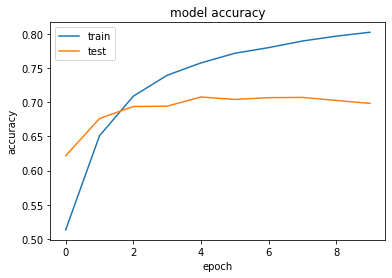

In [26]:
# Plot Accuracy Graph
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluation




You should look at the accuracy of some minority classes in addition to overall accuracy. Signal-non-understanding ('br') is a good indicator of "other-repair," or situations in which the other conversational participant tries to correct the speaker's mistake. In dialogue summarization, the term "summarize/reformulate" ('bf') has been used. Report on the system's accuracy in predicting these classes, as well as any common errors you notice. 

## Minority Classes

In [27]:
# Generate predictions for the test data
predictions = model.predict(test_sentences_X, batch_size=100)

In [28]:
# Build the confusion matrix off these predictions
confusion_matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

In [29]:
print(confusion_matrix)

[[364   2   0 ...   0   0   1]
 [  6  40   0 ...   0   0   1]
 [  0   1   0 ...   0   0  31]
 ...
 [  3   1   0 ...   0   0   0]
 [  0   0   0 ...   0   0   1]
 [  1   4   0 ...   0   0 180]]


In [30]:
# GEt the Accuracy score and Classification Report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print ('Accuracy Score :',accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1)))
print('Classification Report : ')
print (classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

Accuracy Score : 0.6841973453543702
Classification Report : 
              precision    recall  f1-score   support

           0       0.53      0.49      0.51       746
           1       0.22      0.21      0.21       194
           2       0.00      0.00      0.00        66
           3       0.54      0.46      0.49      6988
           4       0.20      0.04      0.07        25
           5       0.15      0.05      0.07       126
           6       0.51      0.84      0.64       312
           7       0.76      0.79      0.77      3710
           8       0.60      0.11      0.18       282
           9       0.30      0.25      0.27       265
          10       0.47      0.31      0.37      2384
          11       0.00      0.00      0.00        26
          12       0.63      0.38      0.47       181
          13       0.00      0.00      0.00        20
          14       0.77      0.94      0.85     10529
          15       0.06      0.03      0.04       214
          16       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# get the 'br' and 'bf' index
one_hot_encoding_dic.idxmax(axis=1)

0                  fc
1                  ad
2                  no
3                  sv
4                  t3
5                  qh
6                  nn
7                   %
8                  bk
9     fo_o_fw_"_by_bc
10                 aa
11                 t1
12                 qo
13                 ft
14                  b
15                 ^2
16                 ^h
17                 br
18                 fp
19                 qw
20                 ng
21                  x
22                qrr
23                 sd
24                 ny
25             aap_am
26                 bd
27                 fa
28             arp_nd
29                  +
30                 ^q
31                 ar
32                 ^g
33                 ba
34               qy^d
35                 bf
36           oo_co_cc
37                 qy
38                b^m
39                 bh
40                 na
41               qw^d
42                  h
dtype: object

In [32]:
# Calculate Accuracies for "br" and "bf"
acc_class = confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)

index_br = list(one_hot_encoding_dic["br"][one_hot_encoding_dic["br"]==1].index)[0]
br_accuracy = acc_class[index_br]*100
print("br accuracy: {}".format(br_accuracy))

index_bf = list(one_hot_encoding_dic["bf"][one_hot_encoding_dic["bf"]==1].index)[0]
bf_accuracy = acc_class[index_bf]*100
print("bf accuracy: {}".format(bf_accuracy))

br accuracy: 60.71428571428571
bf accuracy: 4.733727810650888


## Minority Classes



Minority classes are frequently misidentified as majority classes, owing to the fact that majority classes have significantly more data and thus can be trained on. With 33 percent and 17 percent, respectively, the classes "sd" (40) and "b" (10) are the most common here. 




## Minority Class showcase
The frequencies of the data are plotted in the graph below. This illustrates how some classes are common, while the majority of classes are rare. 

Only 0.13 percent of the data belongs to the "br" class, while 0.42 percent belongs to the "bf" class. 

In [33]:
# Print the frequency of the "br" and "bf" classes
value_counts = reduced_df["act_tag"].value_counts()
bf_frequency = value_counts["bf"]/sum(value_counts)
print("bf frequency: " + str(bf_frequency*100) + "%")

br_frequency = value_counts["br"]/sum(value_counts)
print("br frequency: " + str(br_frequency*100) + "%")

bf frequency: 0.42977379855638936%
br frequency: 0.13371734211067682%


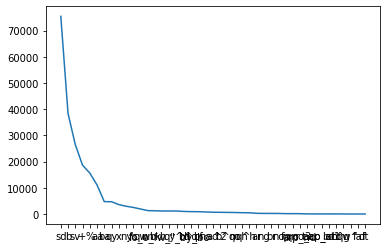

In [34]:
# Plot the frequencies of the classes

plt.plot(value_counts)

# Model 2 - Balanced Network


As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [35]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))

## Define & Train the model

In [36]:
# Re-built the model for the balanced training
model_balanced = Sequential()
# Embedding layer
model_balanced.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length = MAX_LENGTH))
# Bidirectional 1
model_balanced.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences= True)))
# Bidirectional 2
model_balanced.add(Bidirectional(LSTM(HIDDEN_SIZE)))
# Dense layer
model_balanced.add(Dense(HIDDEN_SIZE))
# Activation
model_balanced.add(Activation('softmax'))

model_balanced.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model_balanced.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 100)          4373200   
                                                                 
 bidirectional_2 (Bidirectio  (None, 150, 86)          49536     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 86)               44720     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 43)                3741      
                                                                 
 activation_1 (Activation)   (None, 43)                0         
                                                                 
Total params: 4,471,197
Trainable params: 4,471,197
No

In [37]:
# Train the balanced network - Seems to take long time to achieve good accuracy?
history1 = model_balanced.fit(train_input, train_labels, batch_size=512, epochs=10, validation_data=(val_input, val_labels))

Epoch 1/10
274/274 [==============================] - 72s 237ms/step - loss: 1.7139 - accuracy: 0.5329 - val_loss: 1.2643 - val_accuracy: 0.6563
Epoch 2/10
274/274 [==============================] - 63s 230ms/step - loss: 1.1510 - accuracy: 0.6701 - val_loss: 1.1090 - val_accuracy: 0.6804
Epoch 3/10
274/274 [==============================] - 63s 230ms/step - loss: 0.9802 - accuracy: 0.7149 - val_loss: 1.0286 - val_accuracy: 0.7031
Epoch 4/10
274/274 [==============================] - 63s 231ms/step - loss: 0.8807 - accuracy: 0.7428 - val_loss: 1.0223 - val_accuracy: 0.7048
Epoch 5/10
274/274 [==============================] - 63s 231ms/step - loss: 0.8093 - accuracy: 0.7624 - val_loss: 1.0270 - val_accuracy: 0.7038
Epoch 6/10
274/274 [==============================] - 63s 231ms/step - loss: 0.7574 - accuracy: 0.7750 - val_loss: 1.0222 - val_accuracy: 0.7041
Epoch 7/10
274/274 [==============================] - 63s 231ms/step - loss: 0.7143 - accuracy: 0.7871 - val_loss: 1.0473 - val_ac

## Test the model

In [38]:
# Overall Accuracy
score = model_balanced.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 33s 59ms/step - loss: 1.1268 - accuracy: 0.6841


In [39]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 68.40900182723999


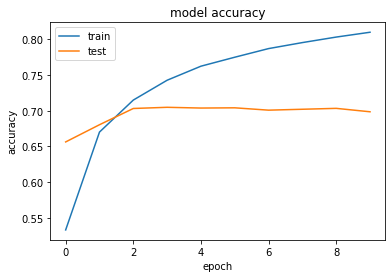

In [40]:
# Plot Accuracy Graph
import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
# Generate predictions for the test data
label_pred = model_balanced.predict(test_sentences_X, batch_size=100)

## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

In [42]:
# Build the confusion matrix off these predictions
confusion_matrix_balanced =  sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))
print(confusion_matrix_balanced)

[[349   9   0 ...   0   0   0]
 [  4  60   0 ...   0   0   0]
 [  1   0   0 ...   0   0  31]
 ...
 [  2   2   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 [  2   0   0 ...   0   0 177]]


In [43]:
# GEt the Accuracy score and Classification Report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print ('Accuracy Score :',accuracy_score(y_test.argmax(axis=1), label_pred.argmax(axis=1)))
print('Classification Report : ')
print (classification_report(y_test.argmax(axis=1), label_pred.argmax(axis=1)))

Accuracy Score : 0.684090014668527
Classification Report : 
              precision    recall  f1-score   support

           0       0.72      0.47      0.57       746
           1       0.23      0.31      0.26       194
           2       0.00      0.00      0.00        66
           3       0.53      0.44      0.48      6988
           4       0.00      0.00      0.00        25
           5       0.06      0.04      0.05       126
           6       0.53      0.83      0.65       312
           7       0.76      0.80      0.78      3710
           8       0.61      0.33      0.43       282
           9       0.27      0.34      0.30       265
          10       0.49      0.30      0.37      2384
          11       0.00      0.00      0.00        26
          12       0.66      0.31      0.43       181
          13       0.50      0.05      0.09        20
          14       0.79      0.92      0.85     10529
          15       0.07      0.02      0.04       214
          16       0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
# Calculate Accuracies for "br" and "bf"
acc_class_balanced = confusion_matrix_balanced.diagonal()/confusion_matrix_balanced.sum(axis=1)

index_br = list(one_hot_encoding_dic["br"][one_hot_encoding_dic["br"]==1].index)[0]
br_accuracy = acc_class_balanced[index_br]*100
print("br accuracy: {}".format(br_accuracy))

index_bf = list(one_hot_encoding_dic["bf"][one_hot_encoding_dic["bf"]==1].index)[0]
bf_accuracy = acc_class_balanced[index_bf]*100
print("bf accuracy: {}".format(bf_accuracy))

br accuracy: 55.35714285714286
bf accuracy: 2.366863905325444






### Explanation



### Other ways to handle imbalanced classes




Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

# Using Context for Dialog Act Classification
We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each utterance for DA classification. Here, we use bidirectional-LSTM (BLSTM) to learn the context before and after the current utterance. 

To make it easier to train, we combined all of the utterances into one long sequence rather than breaking them up into individual dialogues.

## Define the model

This model has an architecture of:

- Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output


## CNN


This is classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes.

In [45]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Input,LSTM
from tensorflow.keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape, Conv2D, BatchNormalization,MaxPool2D,Concatenate, Flatten


filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors)+1 # 43,731
MAX_LENGTH = 150
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

In [46]:
# concatenate tensors
concatenated_tensors = Concatenate()([maxpool_0, maxpool_1, maxpool_2])
# flatten concatenated tensors
flatten_concatenated_tensors = TimeDistributed(Flatten())(concatenated_tensors)
# dense layer (dense_1)
dense_1 = Dense(HIDDEN_SIZE, activation='relu')(flatten_concatenated_tensors)
# dropout_1
dropout_1 = Dropout(drop)(dense_1)

## BLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM.
    

In [47]:
# BLSTM model

# Bidirectional 1
Bidirectional1 = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences='true'))(dropout_1)
# Bidirectional 2
Bidirectional2 = Bidirectional(LSTM(HIDDEN_SIZE))(Bidirectional1)
# Dense layer (dense_2)
dense_2 = Dense(HIDDEN_SIZE, activation='relu')(Bidirectional2)
# dropout_2
dropout_2 = Dropout(drop)(dense_2)


Concatenate 2 last layers and create the output layer
network

In [48]:
# concatenate 2 final layers
flattened_dropout_1 = Flatten()(dropout_1)
concatenate_2_final_layer = Concatenate()([flattened_dropout_1,dropout_2])

# output
output_layer = Dense(HIDDEN_SIZE, input_shape=(1,))(concatenate_2_final_layer)
output = Activation('softmax')(output_layer)

model2 = Model(inputs=[inputs], outputs=[output])

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 150, 100)     4373200     ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 150, 100, 1)  0           ['embedding_2[0][0]']            
                                                                                                  
 conv2d (Conv2D)                (None, 148, 1, 64)   19264       ['reshape[0][0]']                
                                                                                              

Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.
layer

In [49]:
print(HIDDEN_SIZE)

43


In [50]:
# Train the model - use validation 
history2 = model2.fit(train_input, train_labels, batch_size=512, epochs=10, validation_data=(val_input,val_labels))

Epoch 1/10
274/274 [==============================] - 68s 199ms/step - loss: 1.3532 - accuracy: 0.6211 - val_loss: 2.4293 - val_accuracy: 0.6455
Epoch 2/10
274/274 [==============================] - 52s 191ms/step - loss: 0.8926 - accuracy: 0.7303 - val_loss: 1.1294 - val_accuracy: 0.7154
Epoch 3/10
274/274 [==============================] - 52s 191ms/step - loss: 0.7229 - accuracy: 0.7779 - val_loss: 0.9751 - val_accuracy: 0.7086
Epoch 4/10
274/274 [==============================] - 53s 192ms/step - loss: 0.6110 - accuracy: 0.8096 - val_loss: 1.0453 - val_accuracy: 0.7150
Epoch 5/10
274/274 [==============================] - 53s 192ms/step - loss: 0.5315 - accuracy: 0.8310 - val_loss: 1.1225 - val_accuracy: 0.6991
Epoch 6/10
274/274 [==============================] - 52s 192ms/step - loss: 0.4796 - accuracy: 0.8457 - val_loss: 1.2055 - val_accuracy: 0.7024
Epoch 7/10
274/274 [==============================] - 53s 192ms/step - loss: 0.4399 - accuracy: 0.8561 - val_loss: 1.3105 - val_ac

In [51]:
score = model2.evaluate(test_sentences_X, y_test, batch_size=100)

560/560 [==============================] - 9s 15ms/step - loss: 1.5400 - accuracy: 0.6838


In [52]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 68.37501525878906


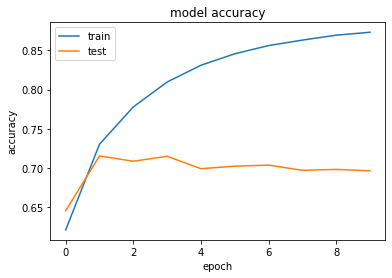

In [53]:
# Plot Accuracy Graph
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
# Generate predictions for the test data
context_pred = model_balanced.predict(test_sentences_X, batch_size=100)

In [55]:
# Build the confusion matrix off these predictions
confusion_matrix_cnn_lstm =  sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), context_pred.argmax(axis=1))
print(confusion_matrix_cnn_lstm)

[[349   9   0 ...   0   0   0]
 [  4  60   0 ...   0   0   0]
 [  1   0   0 ...   0   0  31]
 ...
 [  2   2   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 [  2   0   0 ...   0   0 177]]


In [56]:
# GEt the Accuracy score and Classification Report
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print ('Accuracy Score :',accuracy_score(y_test.argmax(axis=1), context_pred.argmax(axis=1)))
print('Classification Report : ')
print (classification_report(y_test.argmax(axis=1), context_pred.argmax(axis=1)))

Accuracy Score : 0.684090014668527
Classification Report : 
              precision    recall  f1-score   support

           0       0.72      0.47      0.57       746
           1       0.23      0.31      0.26       194
           2       0.00      0.00      0.00        66
           3       0.53      0.44      0.48      6988
           4       0.00      0.00      0.00        25
           5       0.06      0.04      0.05       126
           6       0.53      0.83      0.65       312
           7       0.76      0.80      0.78      3710
           8       0.61      0.33      0.43       282
           9       0.27      0.34      0.30       265
          10       0.49      0.30      0.37      2384
          11       0.00      0.00      0.00        26
          12       0.66      0.31      0.43       181
          13       0.50      0.05      0.09        20
          14       0.79      0.92      0.85     10529
          15       0.07      0.02      0.04       214
          16       0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
# Calculate Accuracies for "br" and "bf"
acc_class_balanced = confusion_matrix_cnn_lstm.diagonal()/confusion_matrix_cnn_lstm.sum(axis=1)

index_br = list(one_hot_encoding_dic["br"][one_hot_encoding_dic["br"]==1].index)[0]
br_accuracy = acc_class_balanced[index_br]*100
print("br accuracy: {}".format(br_accuracy))

index_bf = list(one_hot_encoding_dic["bf"][one_hot_encoding_dic["bf"]==1].index)[0]
bf_accuracy = acc_class_balanced[index_bf]*100
print("bf accuracy: {}".format(bf_accuracy))

br accuracy: 55.35714285714286
bf accuracy: 2.366863905325444
